In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon

ox.config(log_console=True, use_cache=True)

In [8]:
# configure the place, network type, trip times, and travel speed
place = ['Dublin 3, Ireland']
network_type = 'walk'
trip_times = [10, 20, 30] #in minutes
travel_speed = 4.5 #walking speed in km/hour
y= -6.212617986277597 #Latitude cordinates from Google maps (N)
x=  53.36892359047521 #Longitude cordinates from Google maps (E)

In [8]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

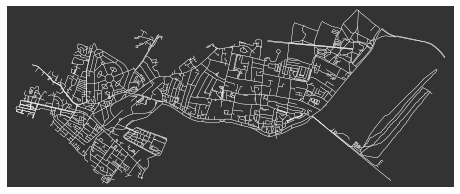

In [9]:
# plot the street network
ox.plot_graph(G,show=False,close=False,bgcolor="#333333",edge_color="w",
    edge_linewidth=0.3,node_size=0.01)

In [10]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
#x, y = gdf_nodes['geometry'].unary_union.centroid.xy #use only if you have no specfic point to calc the catchment from. In this case, it will calc from the city poly centre point
center_node = ox.get_nearest_node(G, (x,y))

/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


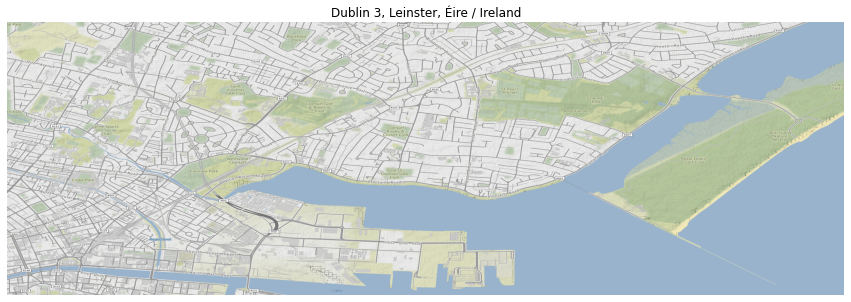

In [11]:
#plot basemap
loc = ctx.Place(place, zoom_adjust=0)  # zoom_adjust modifies the auto-zoom
Basemap=ctx.plot_map(loc)

In [12]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [14]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

In [15]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, Basemap, node_color=nc, node_size=ns, node_alpha=0.3, 
                        node_zorder=2, bgcolor='k', edge_linewidth=0.2, edge_color='#999999', 
                        save=True, dpi=600, figsize=(8,8))

<Figure size 432x288 with 0 Axes>

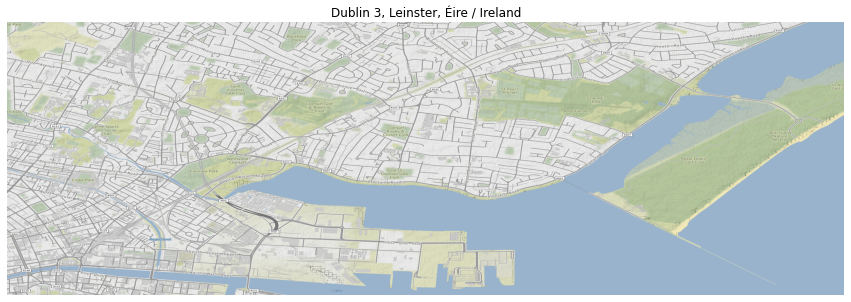

In [16]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly, )
   
Basemap=ctx.plot_map(loc)

In [17]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, Basemap, edge_linewidth=0.2, show=False, close=False, 
                        edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k', 
                        dpi=600, figsize=(8,8))

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.5, zorder=10)
    ax.add_patch(patch)
    ax.legend('123456789', loc=4, ncol=1, borderaxespad=7)

<Figure size 432x288 with 0 Axes>

In [18]:
#add land use data, bus stops and buildings footrint
bus_stops = ox.geometries.geometries_from_place(place, tags={'highway':'bus_stop'})
buildings = ox.geometries_from_place(place, tags={'building':True})
schools = ox.geometries.geometries_from_place(place, tags={'amenity': 'school'})

buildings.plot(ax=ax, color='w', alpha=0.5)
bus_stops.plot(ax=ax, color='b', alpha=0.5)
schools.plot(ax=ax, color='r', alpha=0.5)
    
plt.show()

<Figure size 432x288 with 0 Axes>

In [22]:
#save street network as SVG
fig, ax = ox.plot_graph(G, show=False, save=True, close=True, filepath='./Data/svg/piedmont.svg')

/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
%load_ext watermark
%watermark -v -m -p gepandas, osmnx, numpy, networkx, contextily, descartes, shapely, watermark

print("")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


UsageError: unrecognized arguments: pandas
